# 支持向量机

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

## SVM的原理

多个决策边界，哪个最好？

(-2.5, 5.0)

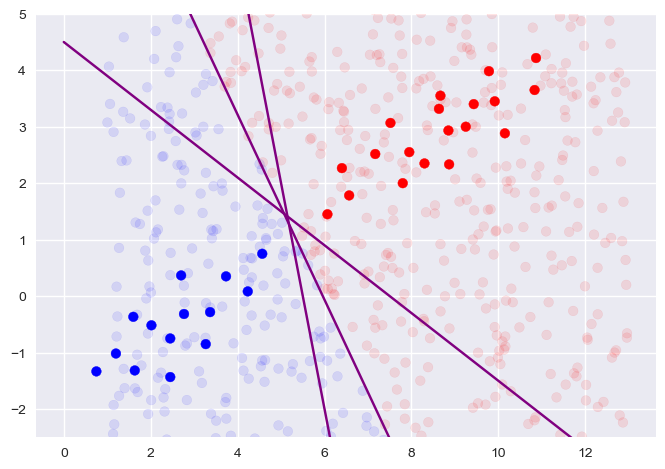

In [2]:
data2 = pd.read_csv('dataset/point dataset (2).csv')

from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(data2[['x', 'y']].values, data2['label'])

plt.scatter(data2['x'], data2['y'], c=data2['label'], cmap='bwr')

_x_range = np.linspace(0, 12, 100)
_X_full = np.random.rand(1000, 2) * [12, 14] + [1, -6]
_y_full = model.predict(_X_full)

plt.plot(_x_range, -4 * _x_range + 22, color='purple')
plt.plot(_x_range, -0.6 * _x_range + 4.5, color='purple')
plt.plot(_x_range, (-model.coef_[0, 0] * _x_range - model.intercept_) / model.coef_[0, 1], color='purple')
plt.scatter(_X_full[:, 0], _X_full[:, 1], c=_y_full, cmap='bwr', alpha=0.1)
plt.ylim(-2.5, 5)


支持向量机(SVM)：大间隔分类器

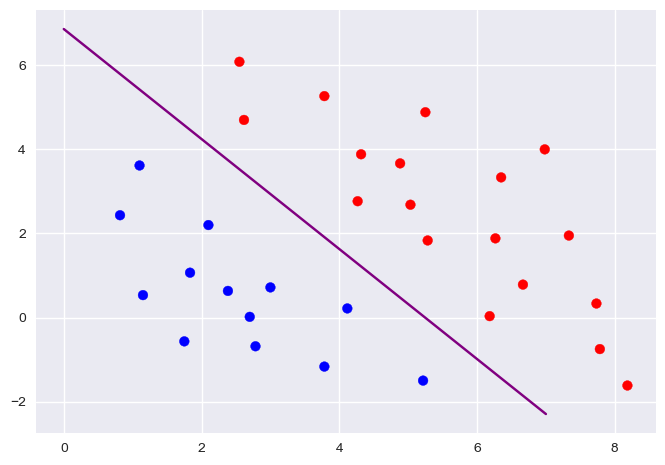

In [3]:
data3 = pd.read_csv('dataset/point dataset (3).csv')

from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(data3[['x', 'y']].values, data3['label'])

_x_range = np.linspace(0, 7, 100)

fig, ax = plt.subplots()

ax.scatter(data3['x'], data3['y'], c=data3['label'], cmap='bwr')
ax.plot(_x_range, (-model.coef_[0, 0] * _x_range - model.intercept_) / model.coef_[0, 1], color='purple')

大间隔的直观展示

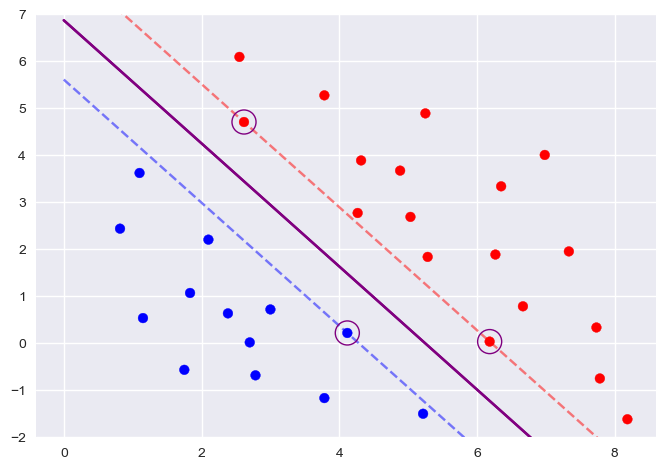

In [4]:

def plot_svm_linear_boundary(model, xlim, ax=None, **params):
    w = model.coef_
    b = model.intercept_
    _x_range = np.linspace(*xlim, 100)
    
    if ax is None:
        raise NotImplementedError()

    boundary = - w[0, 0] / w[0, 1] * _x_range - b / w[0, 1]
    
    margin = 1 / w[0, 1]
    ax.plot(_x_range, boundary, **params.get('style_bd'))
    ax.plot(_x_range, boundary + margin, **params.get('style_up'))
    ax.plot(_x_range, boundary - margin, **params.get('style_down'))
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               **params.get('style_sv'))


plot_styles = dict(
    style_bd=dict(color='purple'),
    style_up=dict(linestyle='dashed', color='red', alpha=0.5, zorder=1),
    style_down=dict(linestyle='dashed', color='blue', alpha=0.5, zorder=1),
    style_sv=dict(s=300, facecolors='none', linewidth=1, edgecolor='purple', zorder=2)
)

plot_svm_linear_boundary(model, (0, 8), ax, **plot_styles)

ax.set_ylim(-2, 7)
fig


支持向量：模型边界上的点决定了决策边界的参数

In [5]:
vects = model.support_vectors_
vects

array([[4.11666667, 0.21666667],
       [2.61666667, 4.7       ],
       [6.18333333, 0.03333333]])

只要支持向量不变，模型的参数就不发生变化：

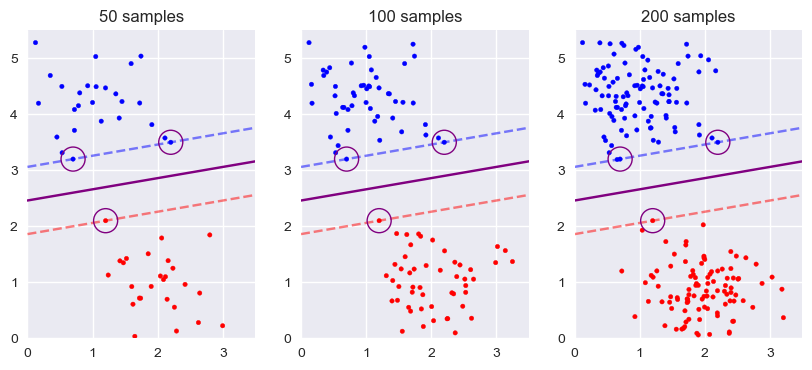

In [6]:
from sklearn.datasets import make_blobs

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i, n in enumerate([50, 100, 200]):
    _X, _y_true = make_blobs(n, centers=2, cluster_std=0.5, random_state=0)
    _X = np.concatenate([_X, [[1.2, 2.1], [0.7, 3.2], [2.2, 3.5]]])
    _y_true = np.concatenate([_y_true, [1, 0, 0]])
    
    model = SVC(kernel='linear', C=10000)
    model.fit(_X, _y_true)

    # plotting
    ax[i].set(xlim=(0, 3.5), ylim=(0, 5.5), title=f'{n} samples')
    ax[i].scatter(_X[:, 0], _X[:, 1], c=_y_true, s=10, cmap='bwr')

    plot_svm_linear_boundary(model, (0, 12), ax[i], **plot_styles)


## SVM的注意事项

### 数据标准化

得到的间隔不对？

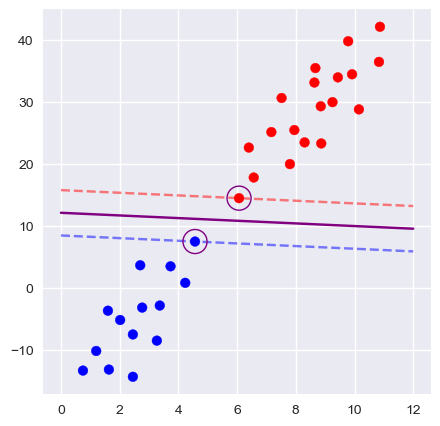

In [7]:

X_scaled = data2[['x', 'y']].values.copy()
X_scaled[:, 1] *= 10

model = SVC(kernel='linear')
model.fit(X_scaled, data2['label'])

# plotting
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=data2['label'], cmap='bwr')

plot_svm_linear_boundary(model, (0, 12), ax, **plot_styles)

SVM 受不同特征变量量纲级别影响较大

解决方法：将数据标准化处理，消除量纲级别影响

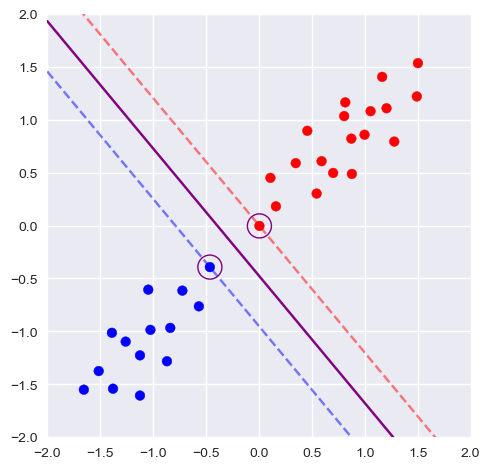

In [8]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_standard = scalar.fit_transform(X_scaled)

model = SVC(kernel='linear', C=100)
model.fit(X_standard, data2['label'])

# plotting
fig, ax = plt.subplots()
ax.scatter(X_standard[:, 0], X_standard[:, 1], c=data2['label'], cmap='bwr')
ax.set(xlim=(-2, 2), ylim=(-2, 2), aspect='equal')

plot_svm_linear_boundary(model, (-2, 2), ax, **plot_styles)

### 软化边界

异常数据的影响

* 使边界被不合理地改变

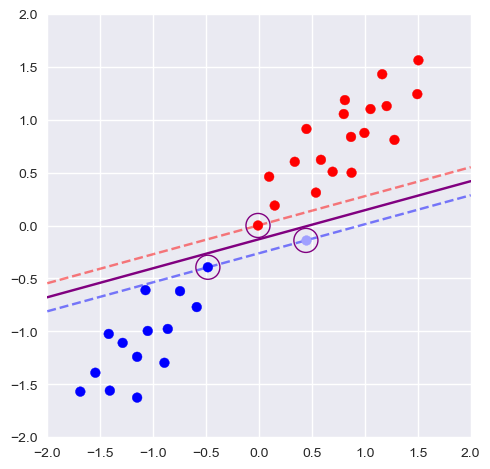

In [9]:
X_worse = np.concatenate([data2[['x', 'y']].values, [[7.5, 1.2]]])
y_worse = np.concatenate([data2['label'], [1]])

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      SVC(kernel='linear', C=10000))
model.fit(X_worse, y_worse)

_X_trans = model.steps[0][1].transform(X_worse)

# plotting
fig, ax = plt.subplots()
ax.scatter(_X_trans[:-1, 0], _X_trans[:-1, 1], c=y_worse[:-1], cmap='bwr')
ax.scatter(_X_trans[-1, 0], _X_trans[-1, 1], c='#A0A0FF', zorder=3)
ax.set(xlim=(-2, 2), ylim=(-2, 2), aspect='equal')

plot_svm_linear_boundary(model.steps[1][1], (-2, 2), ax, **plot_styles)

* 使边界不存在

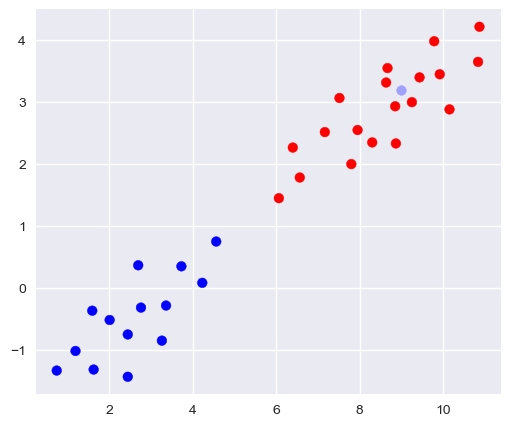

In [10]:
X_worst = np.concatenate([data2[['x', 'y']].values, [[9, 3.2]]])
y_worst = np.concatenate([data2['label'], [1]])

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()
ax.scatter(X_worst[:-1, 0], X_worst[:-1, 1], c=y_worst[:-1], cmap='bwr')
ax.scatter(X_worst[-1, 0], X_worst[-1, 1], c='#A0A0FF', zorder=3)

解决方法：使用超参数 `C` 控制边界软化程度，允许异常数据不严格参与划分

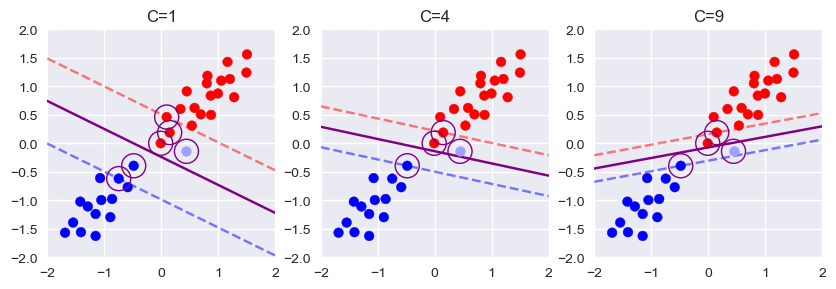

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i in range(3):
    C = (i + 1) ** 2
    model = make_pipeline(StandardScaler(),
                        SVC(kernel='linear', C=C))
    model.fit(X_worse, y_worse)

    _X_trans = model.steps[0][1].transform(X_worse)

    ax[i].scatter(_X_trans[:-1, 0], _X_trans[:-1, 1], c=y_worse[:-1], cmap='bwr')
    ax[i].scatter(_X_trans[-1, 0], _X_trans[-1, 1], c='#A0A0FF', zorder=3)
    ax[i].set(xlim=(-2, 2), ylim=(-2, 2), aspect='equal')
    ax[i].set_title(f'{C=}')
    plot_svm_linear_boundary(model.steps[1][1], (-2, 2), ax[i], **plot_styles)

### 核化SVM

In [12]:
plt.style.use('ggplot')

非线性决策边界的数据：不能被直线分开

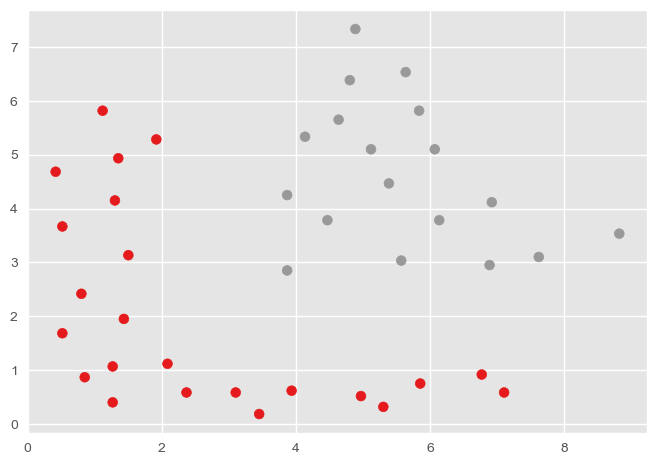

In [13]:
data4 = pd.read_csv('dataset/point dataset (4).csv')
plt.scatter(data4['x'], data4['y'], c=data4['label'], cmap='Set1')

解决方法：引入多项式特征，使数据线性可分

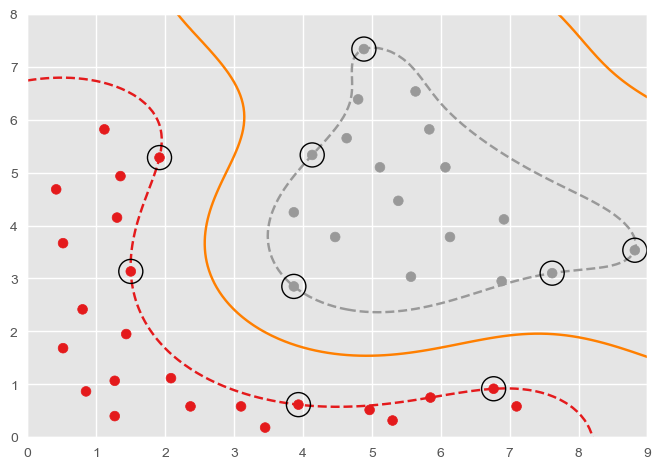

In [14]:
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(PolynomialFeatures(degree=2),
                      StandardScaler(), 
                      SVC(C=6))
model.fit(data4[['x', 'y']].values, data4['label'])

def pipeline_transform(pipeline, X):
    for name, trans in pipeline.steps[:-1]:
        X = trans.transform(X)
    return X

_X, _Y = np.meshgrid(np.linspace(0, 9, 100), 
                     np.linspace(0, 8, 100))
_xy = np.vstack([_X.ravel(), _Y.ravel()]).T
_P = model.decision_function(_xy).reshape(_X.shape) 
_sv = data4[['x', 'y']].values[model.named_steps['svc'].support_]

plt.scatter(data4['x'], data4['y'], c=data4['label'], cmap='Set1')
plt.contour(_X, _Y, _P, levels=[-1, 0, 1], 
            linestyles=['--', '-', '--'], cmap='Set1')
plt.scatter(_sv[:, 0], _sv[:, 1], s=300, 
            facecolors='none', linewidth=1, edgecolor='k', zorder=2)

使用多项式内核，加快运算速度

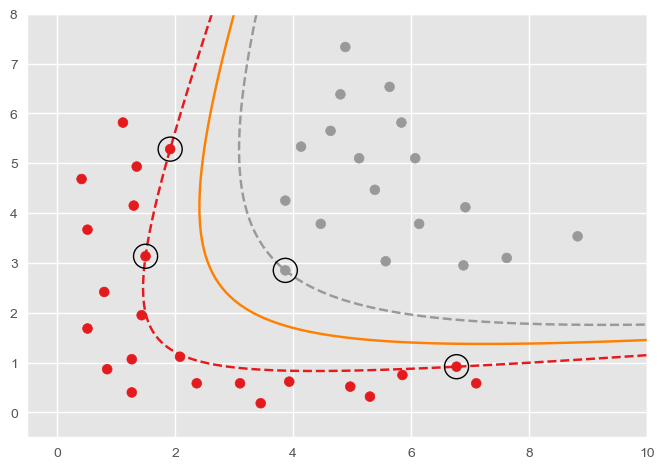

In [15]:
model = SVC(kernel='poly', degree=2, C=10000)
model.fit(data4[['x', 'y']].values, data4['label'])

def plot_svm_decision_boundary(model, xlim, ylim, ax=None, **params):
    """Python DataScience Handbook 2018
    https://github.com/jakevdp/PythonDataScienceHandbook"""
    X, Y = np.meshgrid(np.linspace(*xlim, 100), 
                       np.linspace(*ylim, 100))
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape) 
    ax.contour(X, Y, P, levels=[-1, 0, 1], 
                linestyles=['--', '-', '--'], **params.get('style_bd', {}))
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                **params.get('style_sv', {}))
    
style_kernel = dict(
    style_bd=dict(cmap='Set1'),
    style_sv=dict(s=300, facecolors='none', linewidth=1, edgecolor='k', zorder=2)
)

plt.scatter(data4['x'], data4['y'], c=data4['label'], cmap='Set1')
plot_svm_decision_boundary(model, (-0.5, 10), (-0.5, 8), plt.gca(),
                       **style_kernel)


核化 SVM 的原理：将数据变换到高维空间中，使数据在高维空间中线性可分

示例数据：使用径向基函数(RBF)核变换：

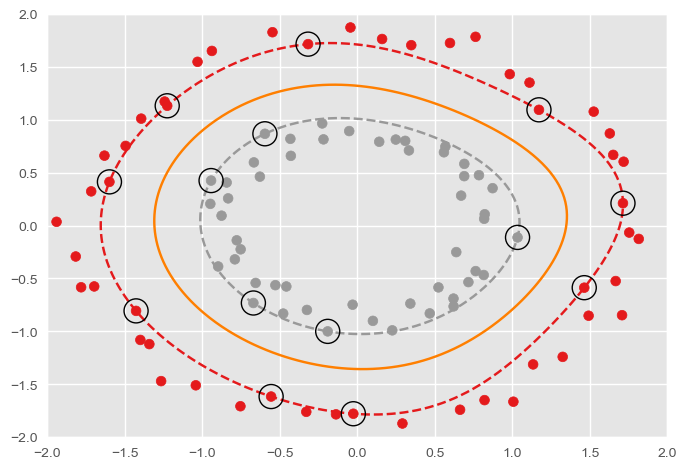

In [16]:
from sklearn.datasets import make_circles

X_circle, y_circle = make_circles(noise=0.05, factor=0.5, random_state=4)

model = make_pipeline(StandardScaler(), 
                      SVC(kernel='rbf', C=10000))
model.fit(X_circle, y_circle)

X_circle_std = model.named_steps['standardscaler'].transform(X_circle)
plt.scatter(X_circle_std[:, 0], X_circle_std[:, 1], c=y_circle, cmap='Set1')
plot_svm_decision_boundary(model.named_steps['svc'], (-2, 2), (-2, 2), plt.gca(),
                       **style_kernel)

将其变换到三维空间中，变得线性可分了：

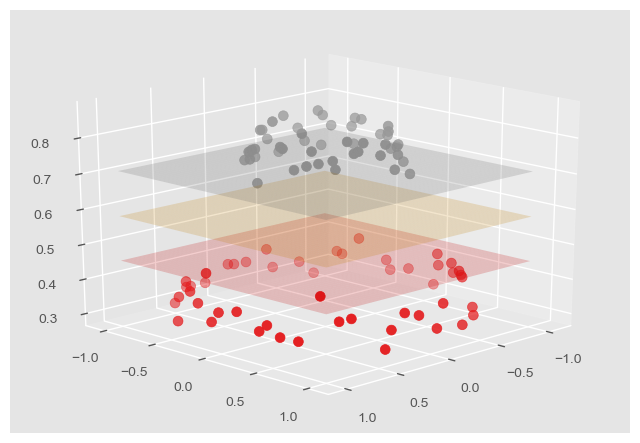

In [17]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(X_circle[:, 0], X_circle[:, 1], np.exp(-(X_circle ** 2).sum(1)), 
             c=y_circle, s=50, cmap='Set1')

_X, _Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
ax.plot_surface(_X, _Y, _X * 0 + 0.710, color='grey', alpha=0.2) 
ax.plot_surface(_X, _Y, _X * 0 + 0.583, color='orange', alpha=0.2) 
ax.plot_surface(_X, _Y, _X * 0 + 0.456, color='red', alpha=0.2) 
ax.view_init(elev=20, azim=45)

换个更好的角度：

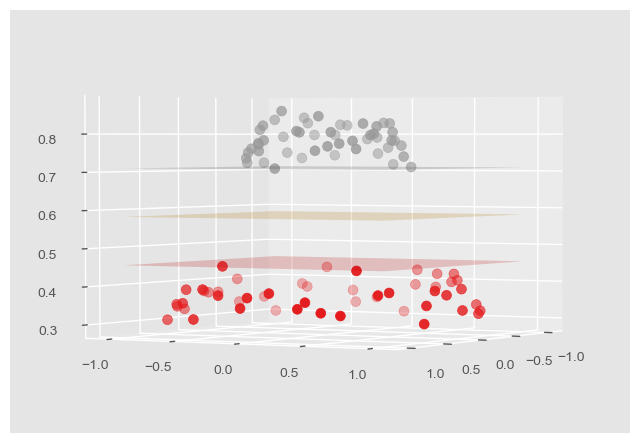

In [18]:
ax.view_init(elev=2, azim=30)
fig

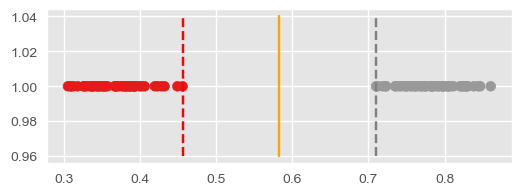

In [19]:
_r = np.exp(-(X_circle ** 2).sum(1))
fig, ax = plt.subplots(figsize=(6, 2))
ax.scatter(_r, _r * 0 + 1, c=y_circle, cmap='Set1')
ax.plot(np.full(2, np.min(_r[_r > 0.6])), [0.96, 1.04], '--', color='grey')
ax.plot(np.full(2, np.max(_r[_r < 0.6])), [0.96, 1.04], '--', color='red')
ax.plot(np.full(2, (np.min(_r[_r > 0.6]) + np.max(_r[_r < 0.6])) / 2), [0.96, 1.04], '-', color='orange')
pass

超参数 `gamma` ：控制 RBF 核的平滑程度，太大可能过拟合

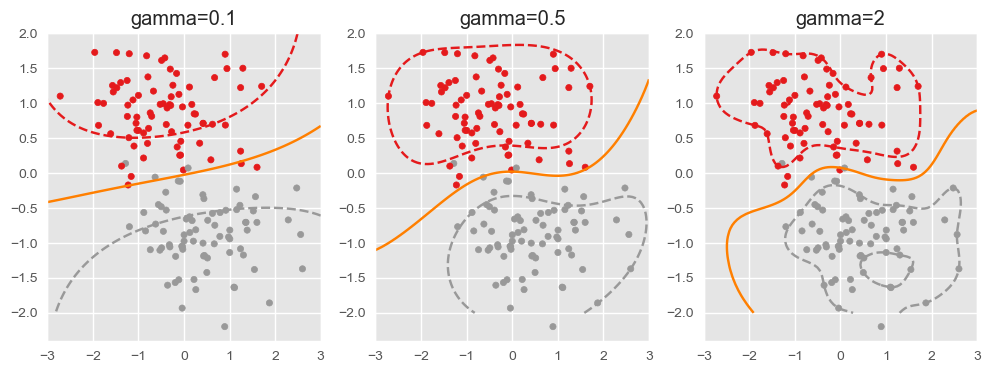

In [20]:
X_gamma, y_gamma = make_blobs(n_samples=150, centers=2, random_state=0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, gamma in zip(axes, [0.1, 0.5, 2]):
    _model = make_pipeline(StandardScaler(),
                           SVC(gamma=gamma))
    _model.fit(X_gamma, y_gamma)
    __X = _model.named_steps['standardscaler'].transform(X_gamma)
    ax.scatter(__X[:, 0], __X[:, 1], c=y_gamma, s=20, cmap='Set1')
    ax.set_title(f'{gamma=}')
    plot_svm_decision_boundary(_model.named_steps['svc'], (-3, 3), (-2, 2), 
                           ax, **(style_kernel | {'style_sv': {'facecolors': 'none'}}))

## 支持向量回归

SVM 也可以用于回归

* SVC ：利用尽可能宽的边界让样本不要被错误分类
* SVR ：利用尽可能宽的边界让样本不要脱离回归直线

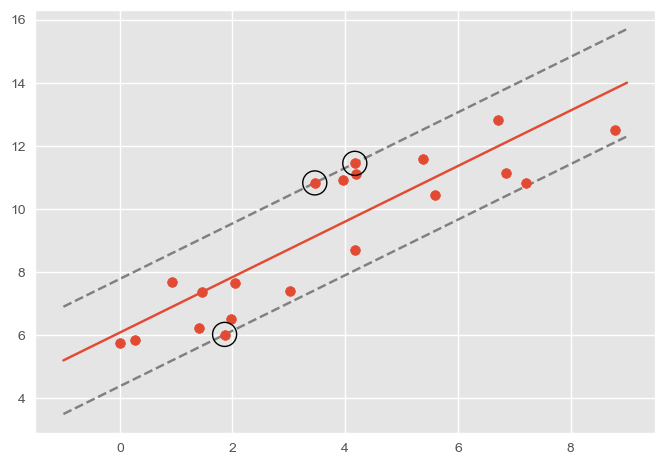

In [21]:
from sklearn.svm import SVR

rand = np.random.RandomState(1)
x = 10 * rand.rand(20)
y = 0.9 * x + 6 + rand.randn(20) * 1.5

model = SVR(kernel='linear', epsilon=1.7)
model.fit(x.reshape(-1, 1), y)

_x_range = np.linspace(-1, 9, 100)
regr = model.predict(_x_range.reshape(-1, 1))

plt.scatter(x, y, zorder=2)
plt.scatter([3.46, 4.17, 1.86], [10.83, 11.45, 6.03], **style_kernel.get('style_sv'))
plt.plot(_x_range, model.predict(_x_range.reshape(-1, 1)))
plt.plot(_x_range, regr - 1.7, '--', color='grey', zorder=1)
plt.plot(_x_range, regr + 1.7, '--', color='grey', zorder=1)



超参数 `epsilon` ：控制模型对偏离数据的容忍程度

Text(-0.5, 6.2, '$\\epsilon$')

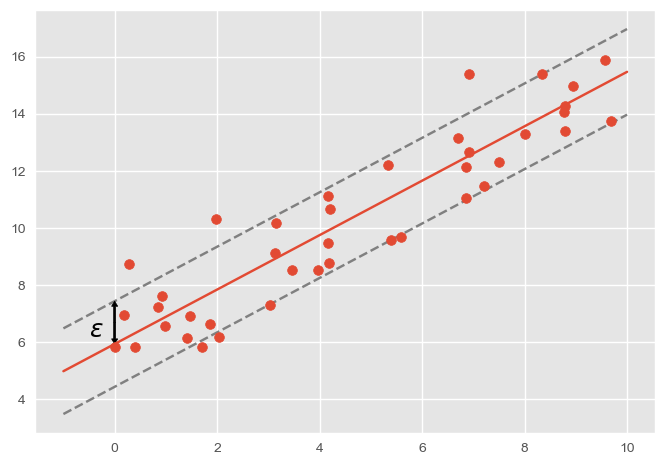

In [22]:
rand = np.random.RandomState(1)
x = 10 * rand.rand(40)
y = 0.9 * x[:40] + 6 + rand.randn(40) * 1.5

model = SVR(kernel='linear', epsilon=1.5)
model.fit(x.reshape(-1, 1), y)

_x_range = np.linspace(-1, 10, 100)
regr = model.predict(_x_range.reshape(-1, 1))

plt.scatter(x, y, zorder=2)
plt.plot(_x_range, model.predict(_x_range.reshape(-1, 1)))
plt.plot(_x_range, regr - 1.5, '--', color='grey', zorder=1)
plt.plot(_x_range, regr + 1.5, '--', color='grey', zorder=1)
plt.arrow(0, model.predict([[0]])[0] + 0.75, 0,  0.75, width=0.04, 
          color='k', shape='full', length_includes_head=True)
plt.arrow(0, model.predict([[0]])[0] + 0.75, 0, -0.75, width=0.04, 
          color='k', shape='full', length_includes_head=True)
plt.text(-0.5, 6.2, '$\epsilon$', fontdict=dict(fontsize=18, color='k'))

太大的 `epsilon` 会因为对异常太包容本身变异常了

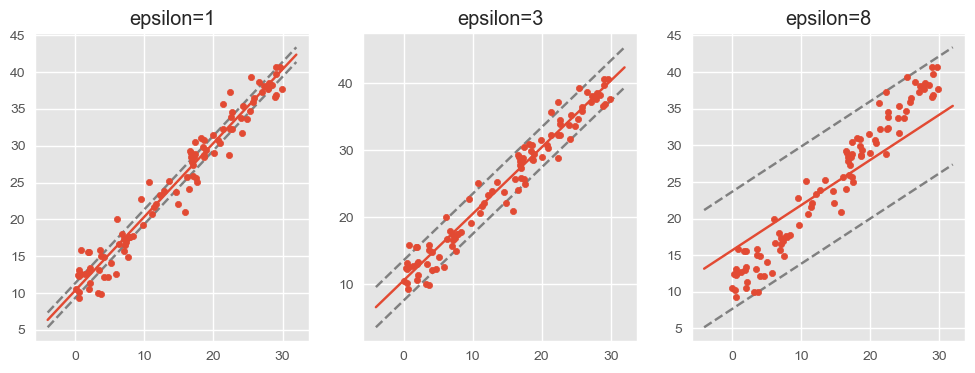

In [23]:
x = 30 * rand.rand(100)
y = x + 10 + rand.randn(100) * 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, eps in zip(axes, [1, 3, 8]):
    model = SVR(kernel='linear', epsilon=eps)
    model.fit(x.reshape(-1, 1), y)

    _x_range = np.linspace(-4, 32, 100)
    regr = model.predict(_x_range.reshape(-1, 1))

    ax.scatter(x, y, s=20, zorder=2)
    ax.set_title(f'epsilon={eps}')
    ax.plot(_x_range, regr)
    ax.plot(_x_range, regr - eps, '--', color='grey', zorder=1)
    ax.plot(_x_range, regr + eps, '--', color='grey', zorder=1)

超参数 `C` ：控制模型的正则化强度

越小的 `C` 正则化强度越高

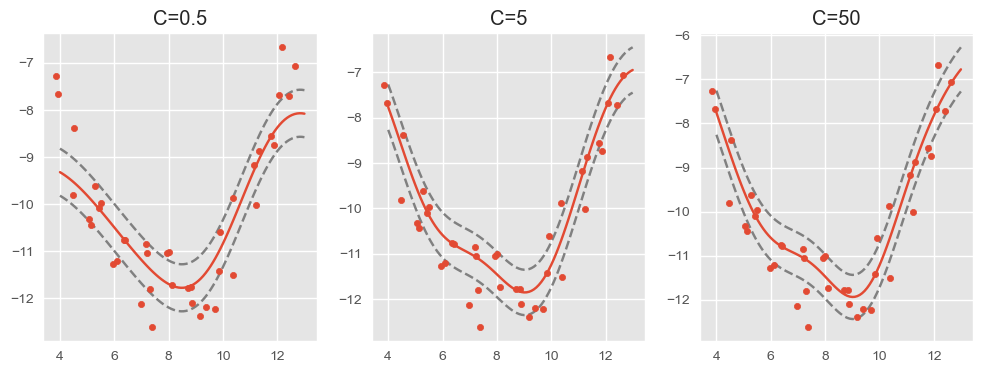

In [24]:
x = np.linspace(3.5, 12, 40) + rand.rand(40)
y = 0.25 * x ** 2 - 4 * x + 3 + rand.random(40) * 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, C in zip(axes, [0.5, 5, 50]):
    model = make_pipeline(StandardScaler(),
                          SVR(kernel='rbf', C=C, epsilon=0.01))
    model.fit(x.reshape(-1, 1), y)

    _x_range = np.linspace(4, 13, 100)
    regr = model.predict(_x_range.reshape(-1, 1))

    ax.scatter(x, y, s=20, zorder=2)
    ax.set_title(f'C={C}')
    ax.plot(_x_range, regr)
    ax.plot(_x_range, regr - 0.5, '--', color='grey', zorder=1)
    ax.plot(_x_range, regr + 0.5, '--', color='grey', zorder=1)